## Drowsiness Detection

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
torch.__version__

'1.13.0+cpu'

In [1]:
from drowsiness_imports import *

###  Data Preparation
The Data Preparation phase includes all activities to create the final data set or data selection that will be loaded into the machine learning model for our classification.The Data Preparation phase includes all activities to create the final data set or data selection that will be loaded into the machine learning model for our classification. This means that we first have to generate new data for the KNN classifier by feature engineering. We also need to make a selection of the data. Since we cannot use all frames of the videos, it makes sense, for example, to extract only a specific range of frames of each video.

#### Functions
Core idea is to use some mathematical measures to have a solid indicator when someone is drowsy. These might be used to create features for classifiers. In particular, following concepts might support the detection:

* If someone is drowsy, then his eyes gets smaller or/and are likely to blink more often. We might capture this change and recognize a closing or blinking of eyes with the *Eye Aspect Ratio (EAR)* formula. 

<img src="img0.png" alt="test" style="display:block;margin-left:auto;margin-right:auto;width:20%">  $$ EAR = \frac{||p_2 - p_6||+||p_3 - p_5||}{2 * ||p_1 - p_4||}$$ </img>

* Since we also have the full faces in the dataset we can capture the ratio of mouth length vs width of the mouth. A corresonding measure would be the *Mouth Aspect Ratio (MAR)* formula.

<img src="Mouth-aspect-ratio-MAR.jpg" alt="test" style="display:block;margin-left:auto;margin-right:auto;width:20%"> 

$$MAR = \frac{|EF|}{|AB|}$$

* A further indicator and probably more accurate indicator may be the *Pupil Circularity (PUC)*. In a sense, it extends the EAR formula, but instead of looking at the whole eye, only the changing pupil is considered.

$$ PUC = \frac{4 * \pi * Area}{perimeter^2}, \;\;\;\;\;\; Area = (\frac{Distance(p2, p5)}{2})^2 * \pi $$

* Another indicator can be created from the ratio of MAR divided by EAR and results in the *Mouth aspect ratio over Eye aspect ratio (MOE)*.

$$ MOE = \frac{MAR}{EAR} $$

In [2]:
# I have put most of the help functions in an extra file so that the notebook remains clearer...
from drowsiness_functions import *

In [3]:
# Read in dlibs shape predictor for detecting facial landmarks
p = r"shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

In [4]:
def datacreation(number ,detector, predictor, cap = cv2.VideoCapture(0)):
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (10,400)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2
    data = []
    cap = cap

    while True:
        # Getting out image by webcam 
        _, image = cap.read()
        # Converting the image to gray scale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Get faces into webcam's image
        rects = detector(image, 0)

        # For each detected face, find the landmark.
        for (i, rect) in enumerate(rects):
            # Make the prediction and transfom it to numpy array
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
            data.append(shape)
            cv2.putText(image,"Calibrating...", bottomLeftCornerOfText, font, fontScale, fontColor,lineType)

            # Draw on our image, all the finded cordinate points (x,y) 
            for (x, y) in shape:
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

        # Show the image
        cv2.imshow("Output", image)

        if cv2.waitKey(1)==ord('q'):
            break

    cv2.destroyAllWindows()
    cap.release()
    
    features_test = []
    for d in data:
        eye = d[36:68]
        ear = eye_aspect_ratio(eye)
        mar = mouth_aspect_ratio(eye)
        cir = circularity(eye)
        mouth_eye = mouth_over_eye(eye)
        features_test.append([number ,ear, mar, cir, mouth_eye])
    
    features_test = np.array(features_test)
    x = features_test
    y = pd.DataFrame(x)
    #y.to_csv('data.csv')
    
    return y

In [5]:
pre=pd.DataFrame()
for number in range(11):
    print("This is Participant number :",number)
    cur= datacreation(number ,detector, predictor, cv2.VideoCapture(0))
    pre=pd.concat([pre,cur])
pre.to_csv('data.csv')

This is Participant number : 0
This is Participant number : 1
This is Participant number : 2
This is Participant number : 3
This is Participant number : 4
This is Participant number : 5
This is Participant number : 6
This is Participant number : 7
This is Participant number : 8
This is Participant number : 9
This is Participant number : 10


In [7]:
df=pd.read_csv(r'data.csv',names=["Participant", "EAR", "MAR", "Circularity", "MOE"])
df

,Participant,EAR,MAR,Circularity,MOE
NaN,0.0,1.000000,2.000000,3.000000,4.000000
0.0,0.0,0.274457,1.123362,0.407315,4.093035
1.0,0.0,0.270384,1.112389,0.429526,4.114106
2.0,0.0,0.280301,1.112389,0.427667,3.968556
3.0,0.0,0.244847,1.123565,0.378870,4.588844
...,...,...,...,...,...
2.0,10.0,0.255684,1.085773,0.364144,4.246544
3.0,10.0,0.255530,1.081895,0.391590,4.233921
4.0,10.0,0.266125,1.112265,0.415079,4.179479
5.0,10.0,0.266125,1.133565,0.415079,4.259519


####  Extract features

In [8]:
df=pd.read_csv(r'data.csv')
row=len(df)
row
df1=pd.read_csv(r'label.csv')
con=df1.head(row)
con
con.to_csv('datalabel.csv')

In [9]:
df_features = [pd.read_csv(f, header=None, names=["Participant", "EAR", "MAR", "Circularity", "MOE"]) for f in glob.glob("data.csv")]
df_labels = [pd.read_csv(f, header=None, names=["Y"]) for f in glob.glob("datalabel.csv")]

df = pd.concat([pd.concat(df_features,ignore_index=True), pd.concat(df_labels,ignore_index=True)], axis=1)
print(df.shape) 
# Save merged file
df.to_csv(r'final.csv',index=False)
df.head()

(175, 6)


,Participant,EAR,MAR,Circularity,MOE,Y
0,0.0,1.000000,2.000000,3.000000,4.000000,0.0
1,0.0,0.274457,1.123362,0.407315,4.093035,0.0
2,0.0,0.270384,1.112389,0.429526,4.114106,0.0
3,0.0,0.280301,1.112389,0.427667,3.968556,0.0
4,0.0,0.244847,1.123565,0.378870,4.588844,0.0


In [4]:
#Reading the CSV back into a dataframe
df_total = pd.read_csv(r'data_drowsiness\merged\totalwithrespondent.csv')

#Reordering the columns
cols = df_total.columns.tolist()
cols = cols[-1:] + cols[4:5] + cols[:4]
df_total = df_total[cols]
df_total

,Y,MOE,Participant,EAR,MAR,Circularity
0,0.0,2.534145,1.0,0.312688,0.792397,0.432896
1,0.0,2.379947,1.0,0.321940,0.766199,0.486923
2,0.0,2.078550,1.0,0.331216,0.688449,0.456029
3,0.0,2.509767,1.0,0.309246,0.776136,0.452655
4,0.0,3.586821,1.0,0.204691,0.734189,0.361123
...,...,...,...,...,...,...
17550,10.0,5.349703,63.0,0.181047,0.968549,0.314714
17551,10.0,5.530147,63.0,0.178874,0.989198,0.306021
17552,10.0,5.536179,63.0,0.180700,1.000386,0.315374
17553,10.0,5.472988,63.0,0.181437,0.993005,0.321619


In [5]:
# Check if a candidate has only 5.0 labeled data
t = df_total.drop_duplicates("Participant")
df_total = df_total[~df_total.Participant.isin(t[t.Y > 0].Participant)]
df_total.shape

(17315, 6)

In [6]:
from drowsiness_standardisation import Standardization
pd.options.mode.chained_assignment = None

# Standardization
df_total = Standardization(df_total).calculate_Standardization()
df_total.head()

(17315, 14)


,Y,MOE,Participant,EAR,MAR,Circularity,EAR_mean,MAR_mean,Circularity_mean,MOE_mean,EAR_std,MAR_std,Circularity_std,MOE_std,EAR_N,MAR_N,Circularity_N,MOE_N
0,0.0,2.534145,1.0,0.312688,0.792397,0.432896,0.321948,0.749015,0.458616,2.330881,0.009264,0.054062,0.027106,0.231727,-0.999551,0.802437,-0.948848,0.877172
1,0.0,2.379947,1.0,0.321940,0.766199,0.486923,0.321948,0.749015,0.458616,2.330881,0.009264,0.054062,0.027106,0.231727,-0.000897,0.317858,1.044306,0.211742
2,0.0,2.078550,1.0,0.331216,0.688449,0.456029,0.321948,0.749015,0.458616,2.330881,0.009264,0.054062,0.027106,0.231727,1.000448,-1.120295,-0.095458,-1.088914
3,0.0,2.509767,1.0,0.309246,0.776136,0.452655,0.321948,0.749015,0.458616,2.330881,0.009264,0.054062,0.027106,0.231727,-1.371052,0.501666,-0.219920,0.771970
4,0.0,3.586821,1.0,0.204691,0.734189,0.361123,0.321948,0.749015,0.458616,2.330881,0.009264,0.054062,0.027106,0.231727,-12.657205,-0.274242,-3.596686,5.419921


In [7]:
# Saving the file to a CSV with all the information
df_total.to_csv(r'data_drowsiness\prepared\totalwithallinfo.csv',index=False)

# Saving the file to a CSV with all the information
df_main = df_total.drop(["EAR_mean","MAR_mean", "Circularity_mean", "MOE_mean", "EAR_std", "MAR_std", "Circularity_std", "MOE_std"], axis=1)
df_main.to_csv(r'data_drowsiness\prepared\totalwithmaininfo.csv',index=False)

###  Modelling
In this phase, we go through the steps to create a model and feed it with the previously prepared data. Key sub-steps are the model development and definition of the parameters as well as initial evaluation steps. The selection of a suitable model is also a central aspect here.

####  KNN-Classifer

Motivated by the article of [Zhong (2019)](https://towardsdatascience.com/drowsiness-detection-with-machine-learning-765a16ca208ahttps://towardsdatascience.com/drowsiness-detection-with-machine-learning-765a16ca208a), the KNN classifier obtained useful results. Therefore, it is worthwhile to apply the classifier again. Maybe we will get a higher accuracy!

In [28]:
# read in prepared data
df = pd.read_csv(r'data_drowsiness\prepared\totalwithmaininfo.csv',sep=',')
participants = set(df.Participant)
df = df.drop(["Participant"], axis=1)
df = df[df.Y != 5.0]  
df.loc[df.Y == 0.0, "Y"] = int(0)
df.loc[df.Y == 10.0, "Y"] = int(1)

train_percentage = 19/22
train_samples = int(len(df) * train_percentage)
test_samples = len(df) - train_samples

df_train = df[:train_samples]
df_test = df[-test_samples:]

X_test = df_test.drop(["Y"], axis=1)
y_test = df_test["Y"]

X_train = df_train.drop('Y', axis=1)
y_train = df_train['Y']
print(f'X_test: {X_test.shape} \ny_test: {y_test.shape} \nX_train: {X_train.shape} \ny_train: {y_train.shape}')
df_train

X_test: (1805, 8) 
y_test: (1805,) 
X_train: (11430, 8) 
y_train: (11430,)


,Y,MOE,EAR,MAR,Circularity,EAR_N,MAR_N,Circularity_N,MOE_N
0,0.0,2.534145,0.312688,0.792397,0.432896,-0.999551,0.802437,-0.948848,0.877172
1,0.0,2.379947,0.321940,0.766199,0.486923,-0.000897,0.317858,1.044306,0.211742
2,0.0,2.078550,0.331216,0.688449,0.456029,1.000448,-1.120295,-0.095458,-1.088914
3,0.0,2.509767,0.309246,0.776136,0.452655,-1.371052,0.501666,-0.219920,0.771970
4,0.0,3.586821,0.204691,0.734189,0.361123,-12.657205,-0.274242,-3.596686,5.419921
...,...,...,...,...,...,...,...,...,...
15505,0.0,4.023086,0.266249,1.071141,0.413992,0.572955,0.886568,0.568597,-0.462667
15506,1.0,7.925377,0.126654,1.003779,0.320008,-1.005326,0.371889,-0.500578,0.773094
15507,1.0,12.127427,0.079901,0.968998,0.304944,-1.533914,0.106153,-0.671949,2.103781
15508,1.0,12.137883,0.081591,0.990339,0.324211,-1.514814,0.269209,-0.452765,2.107092


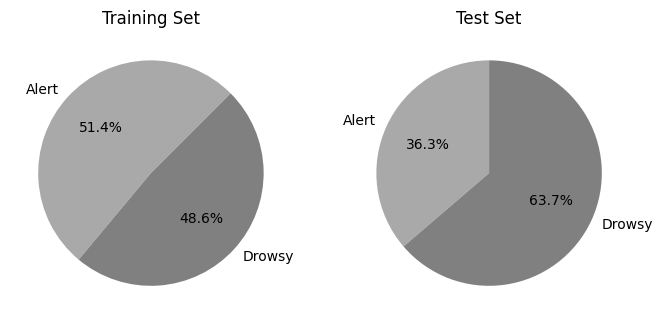

In [29]:
# class distribution
label = 'Alert', 'Drowsy'
plt.figure(figsize = (8,8))
plt.subplot(121)
plt.title("Training Set")
plt.pie(df_train.groupby('Y').size(), labels = label, autopct='%1.1f%%', startangle=45, colors={"grey", "darkgrey"})
plt.subplot(122)
plt.title("Test Set")
plt.pie(df_test.groupby('Y').size(), labels = label, autopct='%1.1f%%', startangle=90, colors={"grey", "darkgrey"})
plt.show()

In [30]:
#KNN classifier
def average(y_pred):
    """Averaging sequential frames for classifier"""
    for i in range(1, len(y_pred)-1):
        if i % 240 == 0 or (i+1) % 240 == 0:
            pass
        else: 
            average = float(y_pred[i-1] + y_pred[i] + y_pred[i+1])/3
            if average >= 0.5:
                y_pred[i] = 1
            else:
                y_pred[i] = 0
    return y_pred

acc3_list = []
f1_score3_list = []
roc_3_list = []

# take 45 runs and save best one
for i in range(1, 45):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train) 
    pred_KN = neigh.predict(X_test)
    pred_KN = average(pred_KN)
    y_score_3 = neigh.predict_proba(X_test)[:,1]
    acc3_list.append(accuracy_score(y_test, pred_KN))
    f1_score3_list.append(metrics.f1_score(y_test, pred_KN))
    roc_3_list.append(metrics.roc_auc_score(y_test, y_score_3))
    
neigh = KNeighborsClassifier(n_neighbors=acc3_list.index(max(acc3_list))+1)
print(f"Neighbors: {neigh.get_params()['n_neighbors']}")
neigh.fit(X_train, y_train) 

Neighbors: 11


KNeighborsClassifier(n_neighbors=11)

In [32]:
def model_knn(landmarks):
    """Returns features and classification result"""
    features = pd.DataFrame(columns=["EAR","MAR","Circularity","MOE"])
    eye = landmarks[36:68] # Extracting relevant parts (eyes + mouth)
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(eye)
    cir = circularity(eye)
    mouth_eye = mouth_over_eye(eye)
    df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)

    # Normalisation
    df["EAR_N"] = (df["EAR"] - mean["EAR"]) / std["EAR"]
    df["MAR_N"] = (df["MAR"] - mean["MAR"]) / std["MAR"]
    df["Circularity_N"] = (df["Circularity"] - mean["Circularity"]) / std["Circularity"]
    df["MOE_N"] = (df["MOE"] - mean["MOE"]) / std["MOE"]
    
    Result = neigh.predict(df)  
    if Result == 1:
        Result_String = "Drowsy"
        fontColor = (0, 0, 245)
    else:
        Result_String = "Alert"
        fontColor = (255, 255, 255)
    
    return Result_String, df.values, fontColor

### Live Demo
So far, so good. The single image classification works quite well, but we want a live detection system! So we need to set up a live-recording on our webcam. Using the following method, we can capture the data stream and switch between the two classification approaches.

In [33]:
def live(knn=False):
    cap=cv2.VideoCapture(0)
    """real-time drowsiness recognition"""
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = 1
    bottomLeftCornerOfText = (10, 400)
    lineType               = 2
    cap                    = cap
    max_prediction         = -1
    frame_counter          = 0
    data                   = []
    result                 = []
    result_bin             = []
    
    while True:
        # Getting out image by webcam 
        _, image = cap.read()

        if not knn:
            # Applying metric based approach
            # Converting the image to gray scale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # Get faces into webcam's image
            rects = detector(image, 0)
             # For each detected face, find the landmark.
            for (i, rect) in enumerate(rects):
                # Make the prediction and transfom it to numpy array
                shape = predictor(gray, rect)
                shape = face_utils.shape_to_np(shape)
                result_string, features, fontColor = model_knn(shape) 
                
                cv2.putText(image, result_string, bottomLeftCornerOfText, font, fontScale, fontColor,lineType)
                data.append (features)
                result.append(result_string)
    
                # Draw on our image, all the finded cordinate points (x,y) 
                for (x, y) in shape:
                    cv2.circle(image, (x, y), 2, (0, 255, 0), -1) # maybe changing red if drowsy, otherwise green
        else:
                # Applying image based approach
                prediction = prediction_cnn(image)
                if (len(result_bin) < 20):
                    if (max_prediction == -1):
                        cv2.putText(image, "Calibration...", bottomLeftCornerOfText, font, fontScale, (255, 255, 255), lineType)
                    else:
                        cv2.putText(image, result_string, bottomLeftCornerOfText, font, fontScale, fontColor, lineType)
                else:                                    
                    max_prediction = np.argmax(np.bincount(result_bin))
                    if (max_prediction == 1):
                        result_string = "Drowsy"
                        fontColor = (0, 0, 245)
                    else:
                        result_string = "Alert"
                        fontColor = (235, 0, 0)
                    cv2.putText(image, result_string, bottomLeftCornerOfText, font, fontScale, fontColor, lineType) #optional
                    result.extend([result_string for i in range(frame_counter)])
                    frame_counter = 0
                    for i in range(int(20/2)):
                        result_bin.pop(0)
                frame_counter += 1
                result_bin.append(prediction)
                
        # Show the image
        cv2.imshow("Output", image)

        if cv2.waitKey(1)==ord('q'):
            break

    cv2.destroyAllWindows()
    cap.release()
    
    return data, result

In [34]:
# Run Calibration (only necessary for KNN classifier)
mean, std = calibration(detector, predictor, cv2.VideoCapture(0))
for i, j in zip(mean, std):
    print("Mean {:4f} and standard deviation {:4f}".format(i, j))

Mean 0.274059 and standard deviation 0.046078
Mean 0.997031 and standard deviation 0.075219
Mean 0.419416 and standard deviation 0.060252
Mean 3.748819 and standard deviation 0.716015


In [35]:
# Run Demonstration with KNN classifier
features, result = live(knn=False)

C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\s

C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\s

C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\s

C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\s

C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\s

C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\s

C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\s

C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\s

C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\s

C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\s

C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\s

C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\s

C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\s

C:\Users\pandi\AppData\Local\Temp\ipykernel_18224\1861531117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
C:\Users\pandi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


###  Evaluation
In this step, we will take a closer look at our trained learning models. Often diagrams and visualizations can support the performance evaluation of the models. There are metrics that can evaluate the grade of a trained model. Many times, decision criteria are evaluated at this stage as to when a model is considered good enough for the business. The definition of these criteria should already appear in the business understanding (i.e. phase 0). If there is still room for improvement in the evaluation step, sometimes the backward step to Business Understanding is necessary (as also recommended by CRISP-DM). Anyway, we will only do a rudimentary evaluation here. We look at the score values of the two classification strategies and also show in which frames we were tired during the stream based on the trained models.

#### Scores of KNN-Classifier

Text(0.5, 0, 'Time (Frames Captured)')

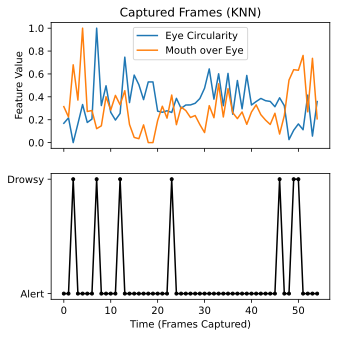

In [18]:
# Plot Results
features =np.vstack(features)
y = pd.DataFrame(features, columns=["EAR","MAR","Circularity","MOE","EAR_N","MAR_N","Circularity_N","MOE_N"])
y = y.drop(columns=["EAR_N","MAR_N","Circularity_N","MOE_N"])

x = y.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
y = pd.DataFrame(x_scaled, columns=["Eye Aspect Ratio","Mouth Aspect Ratio","Eye Circularity","Mouth over Eye"])

y["Result"] = result

fig, (ax1, ax2) = plt.subplots(nrows=2,
                               ncols=1,
                               sharex=True,
                               sharey=False,
                               figsize=(5, 5))

ax1.set_title("Captured Frames (KNN)")
ax1.plot(y["Eye Circularity"])
ax1.plot(y["Mouth over Eye"])
ax1.legend(("Eye Circularity", "Mouth over Eye"), loc="best")
ax1.set_ylabel('Feature Value')

ax2.plot(y["Result"],marker = '.', color = "Black")
ax2.set_xlabel('Time (Frames Captured)')

In [20]:
pred_KN = neigh.predict(X_test)
pred_KN = average(pred_KN)
y_score_3 = neigh.predict_proba(X_test)[:,1]
acc3 = accuracy_score(y_test, pred_KN)
f1_score_3 = metrics.f1_score(y_test, pred_KN)
roc_3 = metrics.roc_auc_score(y_test, y_score_3)
print("Accuracy: {:2f} \nF1-Score: {:2f}".format(acc3*100, f1_score_3*100))
print("ROC: {:2f}".format(roc_3*100))
print("Confusion Matrix")
print(confusion_matrix(y_test, pred_KN))
print(f"Correct classified items {np.trace(confusion_matrix(y_test, pred_KN))} ")
print(f"Based on {y_test.shape[0]} test records")

Accuracy: 90.745637 
F1-Score: 91.946618
ROC: 93.691402
Confusion Matrix
[[717  20]
 [155 999]]
Correct classified items 1716 
Based on 1891 test records
